# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import numpy as np
import tensorflow as tf
import random
import math
import os
import cv2
import pickle
import time
import re

/home/sean/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Constants describing the traffic signs data set.
IMAGE_SIZE = 32                     # Width and height of images. 
CHANNELS = 3                        # Number of color channels (RGB). 
NUM_CLASSES = 43                    # Number of classes. 
NUM_TRAIN_EXAMPLES = 34799          # Number of test instances. 
NUM_VALID_EXAMPLES = 4410           # Number of validation instances. 
NUM_TEST_EXAMPLES = 12630           # Number of validation instances. 

# Constants describing the training process.
BATCH_SIZE = 128                    # Batch size. 
LR_BOUNDARIES = [400, 14000, 18000] # Learning rate boundaries.
LR_VALUES = [0.003, 0.03, 0.003, 0.0003]# Learning rates.
MOMENTUM = 0.9                      # Momentum. 
TRAIN_STEPS = 20000                 # Number of steps to run. 
LOG_FREQUENCY = 1000                # How often to log results.

# Network hyperparameters
BN_MOMENTUM = 0.9                   # Decay rate for batch normalization.
SHORTCUT_L2_SCALE = 0.0001          # Regularization for the skip connections. 
DEPTH = 5                           # Residual units per stack. 
WIDEN_FACTOR = 2                    # Scale up the number of feature maps.

# Constants describing the input pipeline. 
SHUFFLE_BUFFER = NUM_TRAIN_EXAMPLES # Buffer size for the shuffled dataset.
NUM_THREADS = 6                     # Number of threads for image processing. 
OUTPUT_BUFFER_SIZE = BATCH_SIZE*2   # Buffer size for processed images. 
TRAIN_OUTPUT_BUFFER = SHUFFLE_BUFFER//BATCH_SIZE # Train buffer size. 
VALIDATION_OUTPUT_BUFFER = 6        # Buffer size for validation dataset.

# Data directory. 
DATA_DIR = r'/home/sean/Desktop/ml/datasets/traffic-signs-data'

# Directory where to write event logs and checkpoint.
TRAIN_DIR = r'train'

---
## Step 0: Load The Data

In [3]:
training_file = os.path.join(DATA_DIR, "train.p")
validation_file = os.path.join(DATA_DIR, "valid.p")
testing_file = os.path.join(DATA_DIR, "test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels'].astype(np.int32)
X_valid, y_valid = valid['features'], valid['labels'].astype(np.int32)
X_test, y_test = test['features'], test['labels'].astype(np.int32)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
# Number of training examples
n_train = y_train.size

# Number of validation examples
n_validation = y_valid.size

# Number of testing examples.
n_test = y_test.size

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Count the number of items in each class

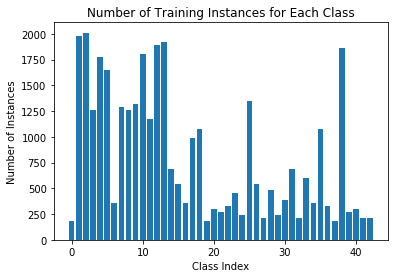

In [5]:
counts = np.zeros(43, dtype=np.float32)
for y in y_train:
    counts[y] += 1
plt.bar(range(0, n_classes), counts)
plt.title("Number of Training Instances for Each Class")
plt.xlabel("Class Index")
plt.ylabel("Number of Instances")
plt.savefig("instances_per_class.png")
plt.show()

Display some of the images and labels

Label: 41


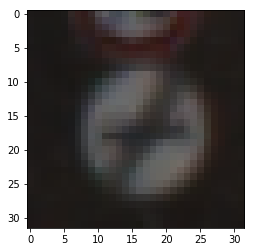

Label: 37


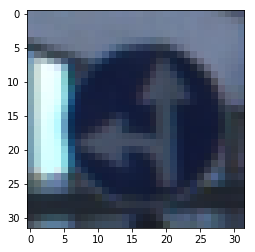

Label: 0


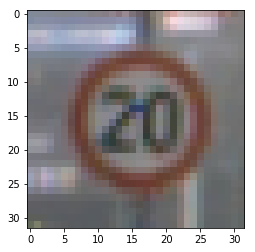

Label: 38


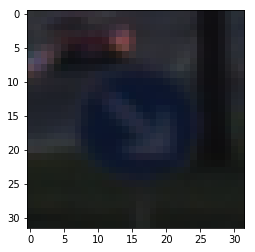

Label: 35


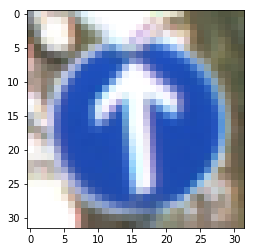

Label: 7


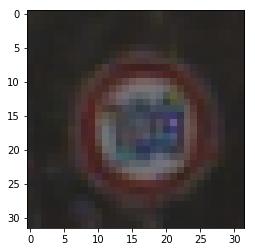

Label: 15


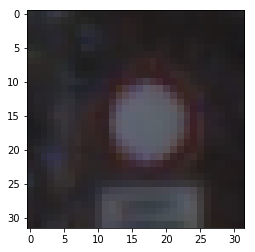

In [6]:
for image, label in zip(X_train[::5000], y_train[::5000]):
    print("Label:",label)
    plt.imshow(image)
    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
def randomization_function(data, label):
    """Apply randomization and standardization to the dataset for training. """
    
    # Randomly crop a section of the image with padding of 4 pixels.
    data = tf.pad(data, [[4,4],[4,4],[0,0]], mode='REFLECT')
    data = tf.random_crop(data, [IMAGE_SIZE, 
                                 IMAGE_SIZE, 
                                 CHANNELS])
    
    # Scale values to range from 0.0 to 1.0 in float32 format.
    data = tf.cast(data, tf.float32)/255.0
    
    return data, label

def standardization_function(data, label):
    """Scale values to range from 0.0 to 1.0 in float32 format. """
    
    data = tf.cast(data, tf.float32)/255.0
    
    return data, label

### Model Architecture

This solution uses a ResNet architecture from a project that I did previously:
https://github.com/seansoleyman/cifar10-resnet

In [8]:
"""Create two sets of BN->relu->conv layers, as well as a shortcut. """
def _residual_block(inputs, filters, initializer, training, stride=1, first=False):
    assert(stride==1 or stride==2)
    bn1 = tf.layers.batch_normalization(
        inputs, 
        momentum=BN_MOMENTUM, 
        training=training, 
        fused=True, 
        scale=False, 
        name='bn1')
    relu1 = tf.nn.relu(bn1, name='relu1')
    conv1 = tf.layers.conv2d(
        relu1, 
        filters=filters, 
        kernel_size=3, 
        strides=stride, 
        padding='same', 
        kernel_initializer=initializer, 
        use_bias=False, 
        name='conv1')
    
    bn2 = tf.layers.batch_normalization(
        conv1, 
        momentum=BN_MOMENTUM, 
        training=training, 
        fused=True, 
        scale=False, 
        name='bn2')
    relu2 = tf.nn.relu(bn2, name='relu2')
    conv2 = tf.layers.conv2d(
        relu2, 
        filters=filters, 
        kernel_size=3, 
        padding='same', 
        kernel_initializer=initializer, 
        use_bias=False, 
        name='conv2')
    
    shortcut = inputs
    if first:
        shortcut = relu1
    if stride==2:
        shortcut = tf.layers.average_pooling2d(shortcut, 2, 2)
        pad = tf.zeros(tf.shape(shortcut), tf.float32, name='pad')
        shortcut = tf.concat([shortcut, pad], axis=3, name='concat')
    
    return tf.add(shortcut, conv2, name='add')

def inference(images, training):
    """Build a ResNet for CIFAR-10.

    Args:
        images: Input for the network. 
            Tensor with shape (batches, height=32, width=32, channels=3). 
        training: Boolean tensor that specifies if the network is
            being trained. This is necessary for batch normalization. 

    Returns:
        A tensor that evaluates scores for the CIFAR-10 classes. 
    """
    initializer = tf.contrib.layers.variance_scaling_initializer()

    with tf.variable_scope('inference_model'):
    
        # Construct the first convolutional layer with no activation. 
        conv1 = tf.layers.conv2d(
            images, 
            filters=16 * WIDEN_FACTOR, 
            kernel_size=3, 
            padding='same', 
            kernel_initializer = initializer,
            use_bias=False, 
            name='conv')
        
        # Stack n residual blocks with 16*WIDEN_FACTOR feature maps sized 32x32. 
        with tf.variable_scope('stack1'):
            block = conv1
            filters = 16 * WIDEN_FACTOR
            with tf.variable_scope('block1'):
                block = _residual_block(block, filters, initializer, training, first=True)
            for i in range(2, DEPTH+1):
                with tf.variable_scope('block{}'.format(i)):
                    block = _residual_block(block, filters, initializer, training)
            
        # Stack n residual blocks with 32*WIDEN_FACTOR feature maps sized 16x16. 
        with tf.variable_scope('stack2'):
            filters *= 2
            with tf.variable_scope('block1'):
                block = _residual_block(block, filters, initializer, training, stride=2)
            for i in range(2, DEPTH+1):
                with tf.variable_scope('block{}'.format(i)):
                    block = _residual_block(block, filters, initializer, training)
            
        # Stack n residual blocks with 64*WIDEN_FACTOR feature maps sized 8x8. 
        with tf.variable_scope('stack3'):
            filters *= 2
            with tf.variable_scope('block1'):
                block = _residual_block(block, filters, initializer, training, stride=2)
            for i in range(2, DEPTH+1):
                with tf.variable_scope('block{}'.format(i)):
                    block = _residual_block(block, filters, initializer, training)
                    
        # Batch Normalization and Rectified Linear Unit layers. 
        bn_final = tf.layers.batch_normalization(
            block, 
            momentum=BN_MOMENTUM, 
            training=training, 
            fused=True, 
            scale=False, 
            name='bn_final')
        relu_final = tf.nn.relu(bn_final, name='relu_final')
    
        # Global Average Pooling and Classifier. 
        global_average_pool = tf.layers.average_pooling2d(
            relu_final, 
            pool_size=(8, 8),
            strides=1, 
            name='global_average_pooling')
        global_average_flat = tf.reshape(
            global_average_pool, 
            [-1, filters], 
            name='flatten')
        logits = tf.layers.dense(
            global_average_flat, 
            units=NUM_CLASSES, 
            kernel_initializer = initializer,
            name='fully_connected')

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [10]:
def total_loss_function(logits, labels):
    """Calculate the total loss including regularization losses. """
    with tf.name_scope('loss'):
        # Calculate the average cross entropy loss across the batch.
        labels = tf.cast(labels, tf.int64)
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=labels, logits=logits, name='cross_entropy_per_example')
        cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
      
        # The total loss is defined as the cross entropy loss plus all of the 
        # weight decay terms (L2 loss).
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        total_loss = tf.add_n(
            [cross_entropy_mean] + reg_losses, name='total_loss')
        
        # Add summaries: regularization losses, cross entropy mean, total loss. 
        for l in reg_losses + [cross_entropy_mean] + [total_loss]:
            tf.summary.scalar(l.op.name, l)
      
        return total_loss

In [11]:
def create_train_op(total_loss, global_step):
    """Create an operation for training the model.

    Args:
        total_loss: total loss from loss().
        global_step: Integer Variable counting the number of training steps
             processed.
    Returns:
        train_op: op for training.
    """
    with tf.name_scope('train_op'):
        # Decay the learning rate based on the number of steps.
        lr = tf.train.piecewise_constant(tf.cast(global_step, tf.int32),
                                         LR_BOUNDARIES,
                                         LR_VALUES)
    
        # Compute gradients.
        opt = tf.train.MomentumOptimizer(lr, 
                                         momentum=MOMENTUM, 
                                         use_nesterov=True)
        grads = opt.compute_gradients(total_loss)
    
        # Apply gradients.
        apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)
      
        # Apply additional operations such as those needed for batch norm
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
        with tf.control_dependencies(
                [apply_gradient_op] + extra_update_ops):
            train_op = tf.no_op(name='train')
    
    return train_op

In [12]:
tf.reset_default_graph()
with tf.device('/cpu:0'), tf.name_scope('input'):
    global_step = tf.train.get_or_create_global_step()

    images_placeholder = tf.placeholder(
            X_train.dtype, 
            (None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), 
            name='images_placeholder')
    labels_placeholder = tf.placeholder(
            y_train.dtype, 
            (None,), 
            name='labels_placeholder')

    train_data_dict = {images_placeholder: X_train, 
        labels_placeholder: y_train}
    valid_data_dict = {images_placeholder: X_valid, 
        labels_placeholder: y_valid}
    test_data_dict = {images_placeholder: X_test, 
        labels_placeholder: y_test}

    training_dataset = tf.data.Dataset.from_tensor_slices(
            (images_placeholder, labels_placeholder))
    training_dataset = training_dataset.prefetch(SHUFFLE_BUFFER)
    training_dataset = training_dataset.map(
            randomization_function, 
            num_parallel_calls=NUM_THREADS)
    training_dataset = training_dataset.shuffle(
            buffer_size=SHUFFLE_BUFFER)
    training_dataset = training_dataset.batch(BATCH_SIZE)
    training_dataset = training_dataset.repeat()
    training_dataset = training_dataset.prefetch(TRAIN_OUTPUT_BUFFER)

    validation_dataset = tf.data.Dataset.from_tensor_slices(
            (images_placeholder, labels_placeholder))
    validation_dataset = validation_dataset.map(
            standardization_function, 
            num_parallel_calls=NUM_THREADS)
    validation_dataset = validation_dataset.batch(
            BATCH_SIZE)
    validation_dataset = validation_dataset.prefetch(
        VALIDATION_OUTPUT_BUFFER)

    iterator = tf.contrib.data.Iterator.from_structure(
            training_dataset.output_types, training_dataset.output_shapes)
    next_element = iterator.get_next()
    training_init_op = iterator.make_initializer(training_dataset)
    validation_init_op = iterator.make_initializer(validation_dataset)

    training_placeholder = tf.placeholder_with_default(
          False, (), name='training_placeholder')

print("Building TensorFlow Graph")

# Build a Graph that computes the logits predictions from the
# inference model.
logits = inference(next_element[0], training=training_placeholder)

# Calculate loss.
total_loss = total_loss_function(logits, next_element[1])

with(tf.name_scope('accuracy')):
    correct = tf.nn.in_top_k(logits, next_element[1], 1)
    number_correct = tf.reduce_sum(tf.cast(correct, tf.int32))

# Build a Graph that trains the model with one batch of examples and
# updates the model parameters.
train_op = create_train_op(total_loss, global_step)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

Building TensorFlow Graph


In [13]:
# Clear the training directory
if tf.gfile.Exists(TRAIN_DIR):
    tf.gfile.DeleteRecursively(TRAIN_DIR)
tf.gfile.MakeDirs(TRAIN_DIR)

In [14]:
print("Starting TensorFlow Session")
best_validation_accuracy = 0.0
with tf.Session() as sess:
    print("Initializing Global Variables")
    init.run()

    print("Training in Progress")
    while global_step.eval() < TRAIN_STEPS:
        # Run a number of training steps set by LOG_FREQUENCY
        training_init_op.run(feed_dict=(train_data_dict))
        start_time = time.perf_counter()
        for _ in range(0,LOG_FREQUENCY):
            batch_loss = sess.run(
                    [train_op, total_loss], 
                    feed_dict={training_placeholder: True})[1:]
        end_time = time.perf_counter()
        average_time_per_step = (end_time-start_time)/LOG_FREQUENCY

        # Calculate error rate based on the full train set.  
        validation_init_op.run(feed_dict=train_data_dict)
        total_correct = 0
        n_train_validation_steps = math.ceil(
                NUM_TRAIN_EXAMPLES/BATCH_SIZE)
        for _ in range(0, n_train_validation_steps):
            total_correct += number_correct.eval()
        train_accuracy = total_correct/NUM_TRAIN_EXAMPLES

        # Calculate error rate based on the full validation set.  
        validation_init_op.run(feed_dict=valid_data_dict)
        total_correct = 0
        n_validation_steps = math.ceil(
                NUM_VALID_EXAMPLES/BATCH_SIZE)
        for _ in range(0, n_validation_steps):
            total_correct += number_correct.eval()
        validation_accuracy = total_correct/NUM_VALID_EXAMPLES
        best_validation_accuracy = max(best_validation_accuracy, validation_accuracy)

        print("Step:", global_step.eval())
        print("  Train Set Accuracy:", train_accuracy)
        print("  Validation Set Accuracy:", validation_accuracy)
        print("  Average Training Time per Step:", average_time_per_step)
    saver.save(sess, os.path.join(TRAIN_DIR, "model.ckpt"))
    print("Best Validation Accuracy:", best_validation_accuracy)

Starting TensorFlow Session
Initializing Global Variables
Training in Progress
Step: 1000
  Train Set Accuracy: 0.9643955286071438
  Validation Set Accuracy: 0.9301587301587302
  Average Training Time per Step: 0.06609455245800018
Step: 2000
  Train Set Accuracy: 0.9996264260467255
  Validation Set Accuracy: 0.9755102040816327
  Average Training Time per Step: 0.06446245949900004
Step: 3000
  Train Set Accuracy: 0.999856317710279
  Validation Set Accuracy: 0.9782312925170068
  Average Training Time per Step: 0.06472106896100013
Step: 4000
  Train Set Accuracy: 1.0
  Validation Set Accuracy: 0.9850340136054422
  Average Training Time per Step: 0.06491785514900039
Step: 5000
  Train Set Accuracy: 1.0
  Validation Set Accuracy: 0.9857142857142858
  Average Training Time per Step: 0.06516644679800083
Step: 6000
  Train Set Accuracy: 1.0
  Validation Set Accuracy: 0.9859410430839002
  Average Training Time per Step: 0.0653319976060011
Step: 7000
  Train Set Accuracy: 1.0
  Validation Set Ac

In [15]:
print("Evaluating on Test Data...")
with tf.Session() as sess:
    saver.restore(sess, os.path.join(TRAIN_DIR, "model.ckpt"))
    validation_init_op.run(feed_dict=test_data_dict)
    total_correct = 0
    n_test_steps = math.ceil(
            NUM_TEST_EXAMPLES/BATCH_SIZE)
    for _ in range(0, n_test_steps):
        total_correct += number_correct.eval()
    test_accuracy = total_correct/NUM_TEST_EXAMPLES
    print("Test Set Accuracy:", test_accuracy)

Evaluating on Test Data...
INFO:tensorflow:Restoring parameters from train/model.ckpt
Test Set Accuracy: 0.9754552652414885


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

22.jpg


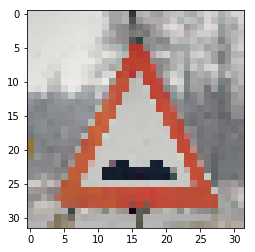

13.jpg


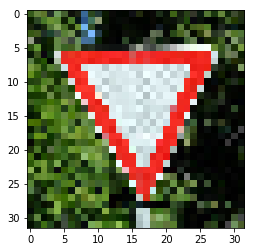

7.jpg


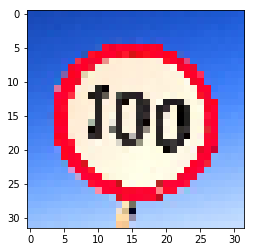

29.jpg


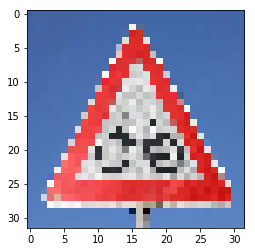

27.jpg


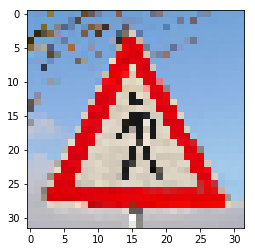

In [16]:
IMAGE_DIR = "downloaded_traffic_signs"
filenames = os.listdir(IMAGE_DIR)
images = []
labels = []
for filename in filenames:
    print(filename)
    labels.append(int(re.match(r"\d+", filename).group(0)))
    image = plt.imread(os.path.join(IMAGE_DIR, filename))
    image = cv2.resize(image, dsize=(32, 32), interpolation=cv2.INTER_NEAREST)
    images.append(image)
    plt.imshow(image)
    plt.show()
X_downloaded = np.array(images, dtype=np.uint8)
y_downloaded = np.array(labels, dtype=np.int32)

### Predict the Sign Type for Each Image

In [17]:
downloaded_data_dict = {images_placeholder: X_downloaded, labels_placeholder: y_downloaded}

In [18]:
print("Making predictions for downloaded data")
with tf.Session() as sess:
    saver.restore(sess, os.path.join(TRAIN_DIR, "model.ckpt"))
    validation_init_op.run(feed_dict=downloaded_data_dict)
    logits_results, total_correct = sess.run([logits, number_correct])
print("Ground Truth:", y_downloaded)
print("Predictions:", np.argmax(logits_results, 1))

Making predictions for downloaded data
INFO:tensorflow:Restoring parameters from train/model.ckpt
Ground Truth: [22 13  7 29 27]
Predictions: [22 13  8 29 27]


### Analyze Performance

In [19]:
test_accuracy = total_correct/5
print("Accuracy on downloaded images:", test_accuracy)

Accuracy on downloaded images: 0.8


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [20]:
tf.reset_default_graph()
logits_placeholder = tf.placeholder(tf.float32, shape=(None, NUM_CLASSES))
softmax = tf.nn.softmax(logits_placeholder, axis=1)
top_5 = tf.nn.top_k(softmax, k=5)
with tf.Session() as sess:
    top_5_eval = sess.run(top_5, feed_dict={logits_placeholder: logits_results})
print(top_5_eval)

TopKV2(values=array([[9.9991298e-01, 4.0890001e-05, 1.6010861e-05, 7.7378363e-06,
        4.3853111e-06],
       [9.9999332e-01, 2.2563086e-06, 1.4478958e-06, 3.6850051e-07,
        3.0994505e-07],
       [5.8217478e-01, 2.7610493e-01, 4.1870181e-02, 3.5495292e-02,
        2.4533352e-02],
       [9.9767250e-01, 4.6261211e-04, 4.1451989e-04, 3.9746915e-04,
        1.5305617e-04],
       [9.4863141e-01, 1.4919022e-02, 1.2767719e-02, 7.9805022e-03,
        6.2072421e-03]], dtype=float32), indices=array([[22, 15, 29, 32, 26],
       [13, 10,  4, 40, 26],
       [ 8,  5,  1,  7,  0],
       [29, 22, 30, 25, 28],
       [27, 24, 28, 21, 11]], dtype=int32))


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.